Link Prediction for Co-Authorship

In [37]:
import copy
import math
import re
from tqdm import tqdm
import numpy as np
import json
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.linalg import norm
import os
import random

**Read True Edges from File**

In [38]:
def get_true_edges(file_path):
    train_file = open(file_path, "r")
    train_text = re.split('\n', train_file.read())
    instances = [re.split('\W+', instance) for instance in train_text]
    true_edges = []
    fake_edges = []
    neighbour_dic = {}
    i = 0
    for j, instance in enumerate(instances):
        if len(instance) > 1:
            while(int(instance[0]) != i):
                neighbour_dic[i] = set()
                i += 1
            neighbour_dic[int(instance[0])] = {i for i in instance[1:] if int(i)!=int(instance[0])}
            i += 1
        true_edges += [(int(instance[0]), int(instance[i])) for i in range(1, len(instance)) if int(instance[i])>int(instance[0])]
        fake_edges += [(int(instance[0]), i) for i in range(len(instances)) if len(instance)>1 and str(i) not in instance[1:] and i > int(instance[0])]
    return true_edges, fake_edges, neighbour_dic
true_edges, fake_edges, neighbour_dic = get_true_edges('train.txt')

In [39]:
fake_edges = fake_edges
print(len(fake_edges))

7910572


**Read Test Edges From File**

In [40]:
def get_test_edges(file_path):
    test_file = open(file_path, "r")
    test_text = re.split('\n', test_file.read())  # edges: 57889-4084=53805
    instances = [re.split('\W+', instance) for instance in test_text]
    test_edges = [(int(instance[1]), int(instance[2])) for instance in instances[1:] if len(instance)==3]
    return test_edges
test_edges = get_test_edges('test-public.csv')

**Get Node Information**

In [41]:
def get_node_feature_from_json(file_path):
    with open(file_path) as json_file:
        data = json.load(json_file)
        feature_data = {}
        for author in data:
            id = author['id']
            feature_data[id] = {}
            feature_data[id] = author
            feature_data[id].pop('id')
        return feature_data
node_file = 'nodes.json'
node_feature_dic = get_node_feature_from_json(node_file)

**Generate Graph**

In [71]:
def generate_graph(true_edges):
    G = nx.Graph()
    G.add_edges_from(true_edges)
    return G
G = generate_graph(true_edges)

**Get Negative Samples**

In [94]:
fake_slice = []
shortest_distance_2 = 3000
for edge in set(fake_edges):
    a1,a2 = edge
    d = 0
    if G.has_node(a1) and G.has_node(a2):
        if nx.has_path(G, source=a1, target=a2):
            if G.has_edge(edge[0],edge[1]):
                G.remove_edge(a1,a2)
                try: d = nx.dijkstra_path_length(G, source=a1, target=a2)
                except: d = 0
                G.add_edge(a1,a2)
            else:
                d = nx.dijkstra_path_length(G, source=a1, target=a2)
    if d==2: 
        fake_slice.append(edge)
        shortest_distance_2 -= 1
    elif len(fake_slice) + shortest_distance_2 <= len(true_edges):
        fake_slice.append(edge)
    else: break

**Matrix**

In [243]:
def get_true_Data(true_edges):
    Data = np.zeros([len(true_edges), 2])
    for i in range(len(true_edges)):
        Data[i][0] = true_edges[i][0]
        Data[i][1] = true_edges[i][1]
    return Data
def get_max_node_num(Data):
    List_A = []
    List_B = []
    for row in range(Data.shape[0]):
        List_A.append(Data[row][0])
        List_B.append(Data[row][1])
    List_A = list(set(List_A))
    List_B = list(set(List_B))
    max_node_num = int(max(max(List_A), max(List_B))) + 1
    return max_node_num
    
def get_Adjacency(max_node_num, Data):
    Adjacency = np.zeros([max_node_num, max_node_num])
    for c in range(Data.shape[0]):
        i = int(Data[c][0])
        j = int(Data[c][1])
        Adjacency[i,j] = 1
        Adjacency[j,i] = 1
    return Adjacency

In [244]:
true_edges = list(true_edges)
Data = get_true_Data(true_edges)
max_node_num = get_max_node_num(Data)
Adjacency = get_Adjacency(max_node_num, Data)

**Split data into Training data and Test data**

In [246]:
train_edges = true_edges+fake_slice
labels = [1]*len(true_edges) + [0]*len(fake_slice)
from sklearn.model_selection import train_test_split
trn_edges, dev_edges, trn_y, dev_y = train_test_split(train_edges, labels, test_size=0.2, random_state=999999,
                                                  stratify=labels)

trn_true_edges = [i for i in trn_edges if G.has_edge(i[0],i[1])]
print(len(trn_edges), len(dev_edges))

42436 10609


In [247]:
trn_Data = get_true_Data(trn_true_edges)
trn_Adjacency = get_Adjacency(max_node_num, trn_Data)

**Topological Features**

In [248]:
def Salton(Adjacency_Train):
    similarity = np.dot(Adjacency_Train,Adjacency_Train)
    deg_row = sum(Adjacency_Train)
    deg_row.shape = (deg_row.shape[0],1)
    deg_row_T = deg_row.T
    tempdeg = np.dot(deg_row,deg_row_T)
    temp = np.sqrt(tempdeg+1)
    np.seterr(divide='ignore', invalid='ignore')
    Matrix_similarity = np.nan_to_num(similarity / temp)
    return Matrix_similarity
def Jaccard(Adjacency_Train):    
    Matrix_similarity = np.dot(Adjacency_Train,Adjacency_Train)
    deg_row = sum(Adjacency_Train)
    deg_row.shape = (deg_row.shape[0],1)
    deg_row_T = deg_row.T
    tempdeg = deg_row + deg_row_T
    temp = tempdeg - Matrix_similarity
    Matrix_similarity = Matrix_similarity / (temp+1)
    return Matrix_similarity
def Sorenson(Adjacency_Train):
    Matrix_similarity = np.dot(Adjacency_Train,Adjacency_Train)
    deg_row = sum(Adjacency_Train)
    deg_row.shape = (deg_row.shape[0],1)
    deg_row_T = deg_row.T
    tempdeg = deg_row + deg_row_T + 1
    Matrix_similarity = (2 * Matrix_similarity) / tempdeg
    return Matrix_similarity
def HDI(Adjacency_Train):
    Matrix_similarity = np.dot(Adjacency_Train,Adjacency_Train)
    deg_row = sum(Adjacency_Train)
    deg_row.shape = (deg_row.shape[0],1)
    deg_row_T = deg_row.T
    tempdeg = np.maximum(deg_row,deg_row_T)
    Matrix_similarity = Matrix_similarity / (tempdeg+1)
    return Matrix_similarity

def AA(Adjacency_Train):
    logTrain = np.log((1+sum(Adjacency_Train)))
    logTrain = np.nan_to_num(logTrain)
    logTrain.shape = (logTrain.shape[0],1)
    Adjacency_Train_Log = Adjacency_Train / logTrain
    Adjacency_Train_Log = np.nan_to_num(Adjacency_Train_Log)
    Matrix_similarity = np.dot(Adjacency_Train,Adjacency_Train_Log)
    return Matrix_similarity
def Katz(Adjacency_Train):
    Parameter = 0.01
    Matrix_EYE = np.eye(Adjacency_Train.shape[0])
    Temp = Matrix_EYE - Adjacency_Train * Parameter
    Matrix_similarity = np.linalg.inv(Temp)
    Matrix_similarity = Matrix_similarity - Matrix_EYE
    return Matrix_similarity
def Cos(Adjacency_Train):     
    Matrix_D = np.diag(sum(Adjacency_Train))
    Matrix_Laplacian = Matrix_D - Adjacency_Train
    INV_Matrix_Laplacian  = np.linalg.pinv(Matrix_Laplacian)
    Array_Diag = np.diag(INV_Matrix_Laplacian)
    Matrix_ONE = np.ones([Adjacency_Train.shape[0],Adjacency_Train.shape[0]])
    Matrix_Diag = Array_Diag * Matrix_ONE
    Matrix_similarity = INV_Matrix_Laplacian/((Matrix_Diag * Matrix_Diag.T) ** 0.5)
    Matrix_similarity = np.nan_to_num(Matrix_similarity)
    return Matrix_similarity
def get_SIM(edges, matrix):
    array = []
    for edge in edges:
        array.append(matrix[edge[0]][edge[1]])
    return array

In [268]:
Matrix_CN = np.dot(Adjacency,Adjacency)
Matrix_Salton = Salton(Adjacency)
Matrix_Jaccard = Jaccard(Adjacency)
Matrix_Sorenson = Sorenson(Adjacency)
Matrix_HDI = HDI(Adjacency)
Matrix_AA = AA(Adjacency)
Matrix_Katz = Katz(trn_Adjacency)
Matrix_Cos = Cos(trn_Adjacency)
# Matrix_Katz = Katz(Adjacency)
# Matrix_Cos = Cos(Adjacency)

In [271]:
trn_cn, dev_cn, test_cn = get_SIM(trn_edges, Matrix_CN), get_SIM(dev_edges, Matrix_CN), get_SIM(test_edges, Matrix_CN)
trn_sal, dev_sal, test_sal = get_SIM(trn_edges, Matrix_Salton), get_SIM(dev_edges, Matrix_Salton), get_SIM(test_edges, Matrix_Salton)
trn_sor, dev_sor, test_sor = get_SIM(trn_edges, Matrix_Sorenson), get_SIM(dev_edges, Matrix_Sorenson), get_SIM(test_edges, Matrix_Sorenson)
trn_jc, dev_jc, test_jc = get_SIM(trn_edges, Matrix_Jaccard), get_SIM(dev_edges, Matrix_Jaccard), get_SIM(test_edges, Matrix_Jaccard)
trn_hdi, dev_hdi, test_hdi = get_SIM(trn_edges, Matrix_HDI), get_SIM(dev_edges, Matrix_HDI), get_SIM(test_edges, Matrix_HDI)

trn_aa, dev_aa, test_aa = get_SIM(trn_edges, Matrix_AA), get_SIM(dev_edges, Matrix_AA), get_SIM(test_edges, Matrix_AA)
trn_kz, dev_kz, test_kz = get_SIM(trn_edges, Matrix_Katz), get_SIM(dev_edges, Matrix_Katz), get_SIM(test_edges, Matrix_Katz)
trn_cos, dev_cos, test_cos = get_SIM(trn_edges, Matrix_Cos), get_SIM(dev_edges, Matrix_Cos), get_SIM(test_edges, Matrix_Cos)
trn_kw, dev_kw, test_kw = get_KW(trn_edges), get_KW(dev_edges), get_KW(test_edges)
trn_vn, dev_vn, test_vn=  get_VN(trn_edges), get_VN(dev_edges), get_VN(test_edges)
trn_td, dev_td,test_td = get_TD(trn_edges),get_TD(dev_edges),get_TD(test_edges)

**Semantic Features**

In [249]:
def get_tfidf():
    kw_features = []
    vn_features = []
    for node_attri in node_feature_dic.values():
        kw_feature = ''
        vn_feature = ''
        for attri in node_attri.keys():
            if 'keyword_' in attri:
                kw_feature += (attri+' ')
            elif 'venue_' in attri:
                vn_feature += (attri+' ')
        kw_features.append(kw_feature)
        vn_features.append(vn_feature)
    tv = TfidfVectorizer()
    feature_vectors = tv.fit_transform(kw_features).toarray()
    venue_vectors = tv.fit_transform(vn_features).toarray()
    return feature_vectors, venue_vectors

def get_tfidf_similarity(vectors,edge):
    node1,node2 = int(edge[0]),int(edge[1])
    if (norm(vectors[node1]) * norm(vectors[node2]))==0:
        return 0
    similarity = np.dot(vectors[node1], vectors[node2]) / (norm(vectors[node1]) * norm(vectors[node2]))
    return similarity
feature_vectors, venue_vectors = get_tfidf()
def get_ckw(edges):
    array = []
    for edge in edges:
        a1,a2 = edge
        keyword_a1 = {kw for kw in node_feature_dic[a1] if 'keyword_' in kw}
        keyword_a2 = {kw for kw in node_feature_dic[a2] if 'keyword_' in kw}
        intersect = keyword_a1.intersection(keyword_a2)
        array.append(len(intersect)/max(1,min(len(keyword_a1), len(keyword_a2))))
    return array
def get_cvn(edges):
    array = []
    for edge in edges:
        a1,a2 = edge
        keyword_a1 = {kw for kw in node_feature_dic[a1] if 'venue_' in kw}
        keyword_a2 = {kw for kw in node_feature_dic[a2] if 'venue_' in kw}
        intersect = keyword_a1.intersection(keyword_a2)
        array.append(len(intersect)/max(1,min(len(keyword_a1), len(keyword_a2))))
    return array
def get_jckw(edges):
    array = []
    for edge in edges:
        a1,a2 = edge
        set1 = {kw for kw in node_feature_dic[a1] if 'keyword_' in kw}
        set2 = {kw for kw in node_feature_dic[a2] if 'keyword_' in kw}
        intersect = set1.intersection(set2)
        union = set1.union(set2)
        array.append(len(intersect)/max(1,len(union)))
    return array
def get_jcvn(edges):
    array = []
    for edge in edges:
        a1,a2 = edge
        set1 = {kw for kw in node_feature_dic[a1] if 'venue_' in kw}
        set2 = {kw for kw in node_feature_dic[a2] if 'venue_' in kw}
        intersect = set1.intersection(set2)
        union = set1.union(set2)
        array.append(len(intersect)/max(1,len(union)))

    return array
def get_KW(edges):
    array = []
    for edge in edges:
        kw = get_tfidf_similarity(feature_vectors, edge)
        array.append(kw)
    return array

def get_VN(edges):
    array = []
    for edge in edges:
        vn = get_tfidf_similarity(venue_vectors, edge)
        array.append(vn)
    return array
def get_TD(edges):
    array = []
    for edge in edges:
        diff = abs(node_feature_dic[edge[0]]['last']-node_feature_dic[edge[1]]['last'])
        if diff == 0: array.append(1)
        else:array.append(1/(diff+1))
    return array

In [269]:
trn_ckw, dev_ckw, test_ckw = get_ckw(trn_edges), get_ckw(dev_edges), get_ckw(test_edges)
trn_cvn, dev_cvn, test_cvn = get_cvn(trn_edges), get_cvn(dev_edges), get_cvn(test_edges)
trn_jckw, dev_jckw, test_jckw = get_jckw(trn_edges), get_jckw(dev_edges), get_jckw(test_edges)
trn_jcvn, dev_jcvn, test_jcvn = get_jcvn(trn_edges), get_jcvn(dev_edges), get_jcvn(test_edges)

**Link Reliability based on Community**

In [ ]:
def BC(G):
    edge_bt = nx.edge_betweenness_centrality(G,normalized=True)
    bc = [(edge, bc) for edge, bc in edge_bt.items()]
    bc = sorted(bc, key=lambda x:x[1], reverse=True)
    return bc
def reliability(components):
    size = len(components)
    Block = np.zeros([size, size])
    HP = 0
    for i, c1 in enumerate(components):
        for j, c2 in enumerate(components):
            if i<=j:
                L = A[list(c1)]
                L = L[:,list(c2)]
                l = np.sum(L) if i!=j else np.sum(L)/2
                r = len(c1)*len(c2) if i!=j else len(c1)*(len(c1)-1)/2
                Block[i][j] = (l+1)/(r+2)
                Block[j][i] = (l+1)/(r+2)
                HP += (math.log(r+1)+ math.log(comb(max(int(r),1),max(int(l),1))))
    return Block, HP

In [1432]:
G2 = G.copy() 
Blocks = []
HPs = []
Nodes = list(G.nodes)
for n in Nodes:
    G.nodes[n]['community'] = []

In [ ]:
while(nx.number_of_edges(G2)>0):
    
    betweenness = BC(G2)
    a1, a2 = betweenness[0][0]
    if betweenness[0][1]==0: break
    initial_components = sorted([i for i in nx.connected_components(G2)], key=lambda x:len(x), reverse=True)
    initial_subgraph = [G2.subgraph(c).copy() for c in nx.connected_components(G2)]
    
    G2.remove_edge(a1, a2)
    
    components = sorted([i for i in nx.connected_components(G2)], key=lambda x:len(x), reverse=True)
    subgraph = [G2.subgraph(c) for c in nx.connected_components(G2)]
    
    length = [nx.number_of_edges(c) for c in subgraph if nx.number_of_edges(c)>10]
    node_num = [len(i) for i in nx.connected_components(G2) if len(i)>10]
    print(nx.number_of_edges(G2),' edges left, ',length,node_num )
        
        
    if len(components)>len(initial_components):
        Block, HP = reliability(components)
        Blocks.append(Block)
        HPs.append(HP)
        for i,c in enumerate(components):
            for n in c: G.nodes[n]['community'].append(i)
        print(len(length),' communities now')
        print('************************************************************')

In [1433]:
def link_reliability(edges):
    array = []
    for edge in edges:
        a1,a2 = edge
        R = 0
        Z = 0
        if G.has_node(a1) and G.has_node(a2):
            a1_community = G.nodes[a1]['community']
            a2_community = G.nodes[a2]['community']

            for i in range(len(Blocks)):
                a1_c = a1_community[i]
                a2_c = a2_community[i] 
                r = Blocks[i][int(a1_c)][int(a2_c)]
                p = (math.e)**(-HPs[i])
                R += r
                Z += p
            R = R/(Z+1)
        array.append(R)
    return array

In [1335]:
trn_rl, dev_rl, test_rl = link_reliability(trn_edges), link_reliability(dev_edges), link_reliability(test_edges)

**Train the model**

In [272]:
def get_features(select, feature_sequence):
    X = []
    Dic = []
    if select['KW']: X.append(feature_sequence[0])
    if select['VN']: X.append(feature_sequence[1])
    if select['TD']: X.append(feature_sequence[2])

    if select['CN']: X.append(feature_sequence[3])
    if select['SAL']: X.append(feature_sequence[4])
    if select['SOR']: X.append(feature_sequence[5])
    if select['JC']: X.append(feature_sequence[6])  
    if select['HDI']: X.append(feature_sequence[7])

    if select['AA']: X.append(feature_sequence[8])
    if select['KZ']: X.append(feature_sequence[9])
    if select['COS']: X.append(feature_sequence[10])
    if select['CKW']: X.append(feature_sequence[11])
    if select['CVN']: X.append(feature_sequence[12])
    if select['JCKW']: X.append(feature_sequence[13])
    if select['JCVN']: X.append(feature_sequence[14])
    if select['RL']: X.append(feature_sequence[15])
    for i in range(len(X[0])):
        diff = {}
        if select['KW']: diff['kw'] = feature_sequence[0][i]
        if select['VN']: diff['vn'] = feature_sequence[1][i]
        if select['TD']: diff['td'] = feature_sequence[2][i]

        if select['CN']: diff['cn'] = feature_sequence[3][i]
        if select['SAL']: diff['sal'] = feature_sequence[4][i]
        if select['SOR']: diff['sor'] = feature_sequence[5][i]
        if select['JC']: diff['jc'] = feature_sequence[6][i] 
        if select['HDI']: diff['hdi'] = feature_sequence[7][i]

        if select['AA']: diff['aa'] = feature_sequence[8][i]
        if select['KZ']: diff['kz'] = feature_sequence[9][i]
        if select['COS']: diff['cos'] = feature_sequence[10][i]
        if select['CKW']: diff['ckw'] = feature_sequence[11][i]
        if select['CVN']: diff['cvn'] = feature_sequence[12][i]
        if select['JCKW']: diff['jckw'] = feature_sequence[13][i]
        if select['JCVN']: diff['jcvn'] = feature_sequence[14][i]
        if select['RL']: diff['rl'] = feature_sequence[15][i]
        Dic.append(diff)
    return np.array(X).T, Dic

In [273]:
feature_select = {'KW':True,'VN':True,'TD':True,
                  'CN':True,'SAL':True, 'SOR':True,'JC':True, 'HDI':True,
                  'AA':True,'KZ':True, 'COS':True,
                 'CKW':True, 'CVN':True, 'JCKW':True, 'JCVN':True,'RL':False}
trn_x, trn_x_dic = get_features(feature_select,[trn_kw, trn_vn, trn_td, trn_cn, trn_sal, trn_sor, trn_jc, trn_hdi,
                                                trn_aa, trn_kz, trn_cos, trn_ckw, trn_cvn, trn_jckw, trn_jcvn, []])

dev_x, dev_x_dic = get_features(feature_select,[dev_kw, dev_vn, dev_td, dev_cn, dev_sal, dev_sor, dev_jc, dev_hdi,
                                                dev_aa, dev_kz, dev_cos, dev_ckw, dev_cvn, dev_jckw, dev_jcvn, []])

test_x, test_x_dic = get_features(feature_select,[test_kw, test_vn, test_td, test_cn, test_sal, test_sor, test_jc, test_hdi,
                                                test_aa, test_kz, test_cos, test_ckw, test_cvn, test_jckw, test_jcvn,[]])


**Logistic Regression**

In [90]:
import matplotlib.pyplot as plt
def plot(clfs, test_auc_list, c_test):
    p = plt.bar([num + 0.25 for num in range(len(clfs))], test_auc_list, 0.5)
    plt.ylabel('AUC')
    plt.title('AUC classifying edge, by classifer')
    plt.ylim([0.6, 1])
    plt.xticks([num + 0.5 for num in range(len(clfs))], (c_test))
    plt.show()

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def train(trn_X,dev_X,trn_y,dev_y):
    parameters = [0.001,0.01,0.1,1,10,10**2,10**3,10**4]

    clfs = [LogisticRegression(penalty='l2',C=c,class_weight='balanced',solver='liblinear') for c in parameters]
    auc_list = []
    best_auc = 0
    best_clf = None
    best_predictions = None
    best_prob= None
#     for clf in clfs:
        clf.fit(trn_X, trn_y)
        predictions = clf.predict(dev_X)
        predict_prob = clf.predict_proba(dev_X)

        auc = round(roc_auc_score(dev_y, predictions), 4)
        if auc > best_auc: 
            best_clf = clf
            best_auc = auc
            best_predictions = predictions
            best_prob = predict_prob
        auc_list.append(auc)
    print('auc:', auc_list)
    print('best auc:',best_auc)
    print('dev_length',len(dev_y))
    print('error:',len([1 for i,p in enumerate(best_predictions) if p!= dev_y[i]]))
    print([i for i in best_clf.coef_])
    plot(clfs, auc_list, parameters)

    return best_clf

(42436, 15) 42436
(10609, 15) 10609
auc: [0.9081, 0.9256, 0.9324, 0.9254, 0.9177, 0.8587, 0.8161, 0.6899]
best auc: 0.9324
dev_length 10609
error: 724
[array([ 6.52391207,  1.13586748, -1.17523139, 10.88672589,  1.19186443,
        0.86732033,  0.7373112 ,  0.71329217,  0.20143907,  1.88837192,
        1.57353786,  2.37009708,  1.5479989 ,  0.04155648,  3.03513803])]


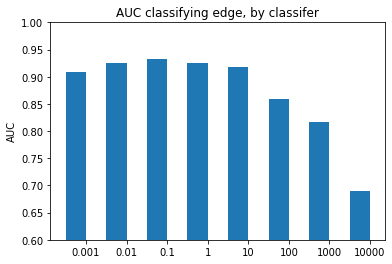

In [274]:
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer()
trn_X = vectorizer.fit_transform(trn_x_dic)
dev_X = vectorizer.transform(dev_x_dic)
test_X = vectorizer.transform(test_x_dic)
print(trn_X.shape, len(trn_y))
print(dev_X.shape,len(dev_y))
best_clf = train(trn_X, dev_X, trn_y, dev_y)
predictions = best_clf.predict_proba(test_X)[:,1]

**Neural Network**

In [276]:
from tensorflow import keras
from tensorflow.keras import regularizers

nn_clf =  keras.models.Sequential([
            keras.layers.Dense(6, activation='relu', input_shape=(15,),kernel_regularizer=keras.regularizers.l2(0.01)),
            keras.layers.Dense(6, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01) ),
            keras.layers.Dense(6, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
            keras.layers.Dense(6, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01) ),
            keras.layers.Dense(6, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
            keras.layers.Dense(6, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),

            keras.layers.Dense(1, activation='sigmoid')
        ])
nn_clf.compile(loss='mse',metrics=[keras.metrics.AUC(), 'accuracy'])
nn_clf.fit(np.array(trn_x),np.array(trn_y),epochs=10)
dev_pred = nn_clf.predict(np.array(dev_x))
print('dev auc:', roc_auc_score(dev_y, dev_pred[:,0]))

Train on 42436 samples
Epoch 1/10
42436/42436 [==============================] - ETA: 37:25 - loss: 0.6610 - auc_6: 0.5000 - accuracy: 0.406 - ETA: 1:23 - loss: 0.6226 - auc_6: 0.8311 - accuracy: 0.627 - ETA: 41s - loss: 0.5967 - auc_6: 0.8749 - accuracy: 0.6943 - ETA: 26s - loss: 0.5721 - auc_6: 0.8909 - accuracy: 0.713 - ETA: 20s - loss: 0.5501 - auc_6: 0.8891 - accuracy: 0.715 - ETA: 15s - loss: 0.5283 - auc_6: 0.8856 - accuracy: 0.713 - ETA: 12s - loss: 0.5082 - auc_6: 0.8869 - accuracy: 0.713 - ETA: 10s - loss: 0.4900 - auc_6: 0.8938 - accuracy: 0.721 - ETA: 9s - loss: 0.4722 - auc_6: 0.8978 - accuracy: 0.731 - ETA: 8s - loss: 0.4560 - auc_6: 0.9021 - accuracy: 0.74 - ETA: 7s - loss: 0.4418 - auc_6: 0.9032 - accuracy: 0.75 - ETA: 6s - loss: 0.4282 - auc_6: 0.9051 - accuracy: 0.76 - ETA: 6s - loss: 0.4161 - auc_6: 0.9068 - accuracy: 0.77 - ETA: 5s - loss: 0.4033 - auc_6: 0.9074 - accuracy: 0.77 - ETA: 5s - loss: 0.3929 - auc_6: 0.9083 - accuracy: 0.78 - ETA: 4s - loss: 0.3828 - auc

42436/42436 [==============================] - ETA: 6s - loss: 0.1109 - auc_6: 0.9784 - accuracy: 0.93 - ETA: 2s - loss: 0.1104 - auc_6: 0.9762 - accuracy: 0.91 - ETA: 2s - loss: 0.1048 - auc_6: 0.9803 - accuracy: 0.92 - ETA: 2s - loss: 0.1067 - auc_6: 0.9787 - accuracy: 0.92 - ETA: 2s - loss: 0.1088 - auc_6: 0.9768 - accuracy: 0.92 - ETA: 2s - loss: 0.1092 - auc_6: 0.9760 - accuracy: 0.92 - ETA: 2s - loss: 0.1086 - auc_6: 0.9758 - accuracy: 0.92 - ETA: 2s - loss: 0.1077 - auc_6: 0.9765 - accuracy: 0.92 - ETA: 2s - loss: 0.1085 - auc_6: 0.9761 - accuracy: 0.92 - ETA: 2s - loss: 0.1080 - auc_6: 0.9765 - accuracy: 0.92 - ETA: 2s - loss: 0.1071 - auc_6: 0.9774 - accuracy: 0.92 - ETA: 2s - loss: 0.1079 - auc_6: 0.9765 - accuracy: 0.92 - ETA: 2s - loss: 0.1080 - auc_6: 0.9765 - accuracy: 0.92 - ETA: 2s - loss: 0.1079 - auc_6: 0.9764 - accuracy: 0.92 - ETA: 2s - loss: 0.1086 - auc_6: 0.9758 - accuracy: 0.92 - ETA: 2s - loss: 0.1085 - auc_6: 0.9758 - accuracy: 0.92 - ETA: 2s - loss: 0.1090 - 

42436/42436 [==============================] - ETA: 9s - loss: 0.0999 - auc_6: 0.9843 - accuracy: 0.93 - ETA: 2s - loss: 0.1138 - auc_6: 0.9704 - accuracy: 0.91 - ETA: 2s - loss: 0.1073 - auc_6: 0.9754 - accuracy: 0.92 - ETA: 2s - loss: 0.1061 - auc_6: 0.9761 - accuracy: 0.92 - ETA: 2s - loss: 0.1057 - auc_6: 0.9762 - accuracy: 0.92 - ETA: 2s - loss: 0.1044 - auc_6: 0.9777 - accuracy: 0.92 - ETA: 2s - loss: 0.1036 - auc_6: 0.9781 - accuracy: 0.92 - ETA: 2s - loss: 0.1047 - auc_6: 0.9774 - accuracy: 0.92 - ETA: 2s - loss: 0.1044 - auc_6: 0.9776 - accuracy: 0.92 - ETA: 2s - loss: 0.1048 - auc_6: 0.9775 - accuracy: 0.92 - ETA: 2s - loss: 0.1040 - auc_6: 0.9783 - accuracy: 0.92 - ETA: 2s - loss: 0.1033 - auc_6: 0.9786 - accuracy: 0.93 - ETA: 2s - loss: 0.1026 - auc_6: 0.9793 - accuracy: 0.93 - ETA: 2s - loss: 0.1024 - auc_6: 0.9795 - accuracy: 0.93 - ETA: 2s - loss: 0.1017 - auc_6: 0.9802 - accuracy: 0.93 - ETA: 1s - loss: 0.1018 - auc_6: 0.9800 - accuracy: 0.93 - ETA: 1s - loss: 0.1018 - 

In [278]:
predictions = nn_clf.predict_proba(test_x)[:,0]

In [1452]:
import csv
def write_file(predictions, file_path):
    file = open(file_path, 'a', encoding='utf-8', newline='')
    csv_writer = csv.writer(file, dialect='excel')
    for p in predictions:
        csv_writer.writerow([p, ])
write_file(predictions,'test-prediction.csv')